<a href="https://colab.research.google.com/github/wfsilva-uea/tweet-covid/blob/master/tweet_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


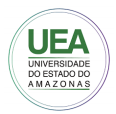
# Pós-graduação Lato Sensu em Ciência de Dados
# Programação para Ciência de Dados
## Relatório Análise Questionamentos COVID-19

> Equipe : Wendel Silva e Samuel Galiza

O trabalho consiste em carregar um 'dataset' com mais de um milhão de seiscentas(1.600.000,00) mensagens, tendo com fonte de dados a plataforma de mídia: Twitter, e extrair os principais questionamentos relacionados ao COVID-19. 


## Importar dependências



 * Mapear pasta Google Drive para acesso ao repositório contendo o arquivo '*.csv' com as mensagens de twiters; 
 * Montar o diretório na máquina 'colab'.

In [159]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* Importar funcionalidades da biblioteca NLTK para o processamento sobre linguagens naturais para tratar o texto.




In [160]:
import nltk
nltk.download('punkt')
nltk.download('rslp')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

* Importar bibliotecas úteis que fornece ferramentas de análise de dados e estruturas de dados. 

In [161]:
import re
import numpy as np

import pandas as pd
pd.options.mode.chained_assignment = None

* Importar bibliotecas para plotagem de gráficos.

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')

* Importar biblioteca para tratar acentuação das palavras

In [163]:
from unicodedata import normalize

## Treinar modelo para classificação

Na computação, uma stopword (palavra vazia) é uma palavra que é removida antes ou após o processamento de um texto em linguagem natural.

In [137]:
from nltk.corpus import stopwords
stopwords = stopwords.words('portuguese')

A classe RSLPStemmer serve para diminuirmos a palavra até a sua raiz/base, pois assim, conseguimos tratar as palavras originais e suas respectivas derivações de uma mesma maneira. Exemplo: As palavras Correr e Corrida quando submetidas à nossa função de stemming, ambas as palavras serão diminuídas até a base Corr. 

A funcão abaixo irá quebrar a frase em palavras, remover os acentos e palavras vazias (stopwords) e diminuir a palavra até sua base.

In [138]:
from nltk import stem
stemmer = stem.RSLPStemmer()

def normalize_texto(texto):
  texto = re.sub('[!-@[-`{-¿ÆÐÑ×ØÝ-ßä-æëðñö-øý-ÿ]', '', texto)
  texto = normalize('NFKD', texto).encode('ASCII', 'ignore').decode('ASCII')
  texto = texto.lower()
  texto = nltk.word_tokenize(texto)
  return [stemmer.stem(word) for word in texto if word not in stopwords]

Função para treinar os o conjunto de dados modelo contendo as 4 classes (organizações, medicamento, doença e pessoas)

In [139]:
def treinar(dados):
  classes = {}

  for idx, rows in dados.iterrows():        
    cls = rows['classificacao']
    if cls not in classes:
      classes[cls] = {}

    normalizado = normalize_texto(rows['texto'])
    for t in normalizado:
      if t not in classes[cls]:
        classes[cls][t] = 1
      else:
        classes[cls][t] += 1
  return classes

Carregar dataset de classificação e treinar modelo

In [140]:
classificador = pd.read_csv('/content/drive/My Drive/dataset/classificador.csv')
classificador = treinar(classificador)

Calcular a pontuação de cada palavra do texto

In [141]:
def calcular_pontuacao(texto, classe):
  pontuacao = 0 
  normalizado = normalize_texto(texto)
  for t in normalizado:
    if t in classificador[classe]:
      pontuacao += classificador[classe][t]
  return pontuacao

Classificar o texto de acordo com a pontuação das palavras

In [142]:
def classifique(texto):
  classe = 'outros'
  pontuacao = 0   
  for cls in classificador.keys():
    pontuacao_atual = calcular_pontuacao(texto, cls)
    if pontuacao_atual > pontuacao:
      classe, pontuacao = cls, pontuacao_atual
  return classe, pontuacao

In [143]:
classifique("""Cloroquina faz mal pra saude?""")

('medicamento', 1)

## Carregar dataset e extrair o DuvidasDB

* Carregar dataset de twiters e armazenar em um dataframe pandas

In [131]:
df = pd.read_csv('/content/drive/My Drive/dataset/dados-curso-completo.csv')

Verificar se o texto possui pelo menos uma interrogação, caso não substituir o texto por None. O propósito é diminuir o tempo de execução na etapa de classificação, garantindo que o dataset tenha apenas publicações com perguntas.

In [132]:
duvidas = df['texto'].apply(lambda t: t if '?' in t else None).notnull()
DuvidasDB = df[duvidas]

In [133]:
DuvidasDB.head()

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-03-23 18:51:14,Gaboardi,fraslee,@BolsonaroSP Cade o fundão deputado??? Congres...,0,138,pt,NaN,NaN,NaN,NaN,NaN,[]
3,2020-04-01 21:11:07,🚩,santosodeto,Fumaça de cigarro pode propagar coronavírus? h...,0,1885,pt,NaN,NaN,NaN,NaN,NaN,[]
38,2020-06-25 11:09:19,Andreia Peraro,AndreiaPeraro,@ipratesMD @dr_pampers Será que corremos o ris...,0,86,pt,NaN,NaN,NaN,NaN,NaN,[]
45,2020-04-06 15:44:36,Diorgenes Pandini,diorpandini,Prioridade ?!\n\n #COVID19 #floripa #isolament...,0,219,pt,NaN,NaN,NaN,NaN,NaN,"['COVID19', 'floripa', 'isolamento']"
57,2020-03-30 00:43:36,Valnei do Val,vdoval,"Que tal uma notícia boa, indo na contramão do ...",0,201,pt,NaN,NaN,NaN,NaN,NaN,[]


Criar coluna para armazenar apenas as perguntas e classes do dataset

In [134]:
DuvidasDB['pergunta'] = ''
DuvidasDB['classe'] = ''

Quebrar a coluna de texto em setenças usando a biblioteca nltk, este recurso divide um texto em uma lista de frases, usando um algoritmo não supervisionado para construir um modelo para abreviações de palavras, colocações e palavras que iniciam frases. 

In [136]:
from nltk import tokenize
DuvidasDB['texto'] = DuvidasDB['texto'].apply(tokenize.sent_tokenize)

Classificar 'DuvidasDB' utilizando base de classificador.csv



In [149]:
for idx, data in DuvidasDB.iterrows():
  perguntas = set()
  classes = set()
  for texto in data['texto']:
    if '?' in texto:
      cls, frequencia = classifique(texto)
      perguntas.add(texto)
      classes.add(cls)
  
  if len(classes) > 1:
    classes.discard('outros')
  
  DuvidasDB.at[idx, 'pergunta'] = perguntas
  DuvidasDB.at[idx, 'classe'] = ','.join(classes)

In [150]:
DuvidasDB[['pergunta', 'classe']].head(10)

,pergunta,classe
0,{@BolsonaroSP Cade o fundão deputado???},pessoas
3,{Fumaça de cigarro pode propagar coronavírus?},doenca
38,{@ipratesMD @dr_pampers Será que corremos o ri...,outros
45,{Prioridade ?!},outros
57,"{Que tal uma notícia boa, indo na contramão do...",organizacoes
73,{@JoseMedeirosMT Seria isso algum tipo aleatór...,doenca
77,"{""Nova York é o novo epicentro da pandemia de ...",doenca
116,{@mitags Será por que o Bolsonaro não fez prop...,pessoas
118,{@JeanSCorrea7 Mas ele não deu a entender que ...,medicamento
119,{#perguntacorona \nQuero saber se a covid tem ...,doenca


In [151]:
DuvidasDB.to_csv('/content/drive/My Drive/dataset/perguntas_classificadas.csv')

## Comparativo massa de dados Antes/Após classificação

In [128]:
df = pd.read_csv('/content/drive/My Drive/dataset/dados-curso-completo.csv')
DuvidasDB = pd.read_csv('/content/drive/My Drive/dataset/perguntas_classificadas.csv')

In [157]:
def formata_valor(valor):
  return '{:,.2f}'.format(valor).replace(',', ' ')

* Massa de dados inicial, antes e depois da classificação

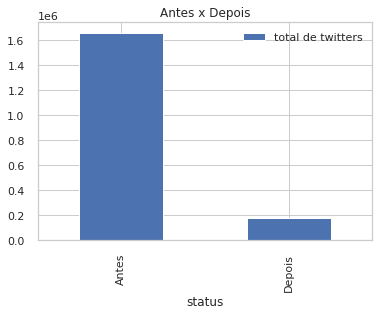

In [165]:
data = [
    ['Antes', df.shape[0]],
    ['Depois', DuvidasDB.shape[0]]
]
df_plot = pd.DataFrame(data, index=[0, 1], columns=['status', 'total de twitters'])
plot = df_plot.plot(kind='bar', x='status', y='total de twitters')
plot.set_title('Antes x Depois')
plt.show()

* Verificamos as colunas com mais valores ausentes para esse dataset e notamos que 95% dos usuários não informam os dados de sua localização

In [62]:
df_size = df.shape[0]
df_plot = df.isnull().sum().sort_values(ascending=False).to_frame(name='total').head()
df_plot['total'] = df_plot['total'].apply(lambda t: '%.2f%%' % (t * 100 / df_size))
df_plot

,total
longitude,99.47%
latitude,99.47%
sigla,95.50%
pais,95.50%
lugar,95.50%


1. Sabendo que a carga de dados efetuada é um total de 1.658.825 linhas, podemos perceber que as variáveis acima não representam importância pois quase da sua totalidade está com valores vazios(NaN).

2. Representando graficante, é possivel ver a distrbuição quase que igualitária de campos vazios no DataFrame fornecido




Text(0.5, 1.0, '% DISTRIBUICAO DE DADOS NAN')

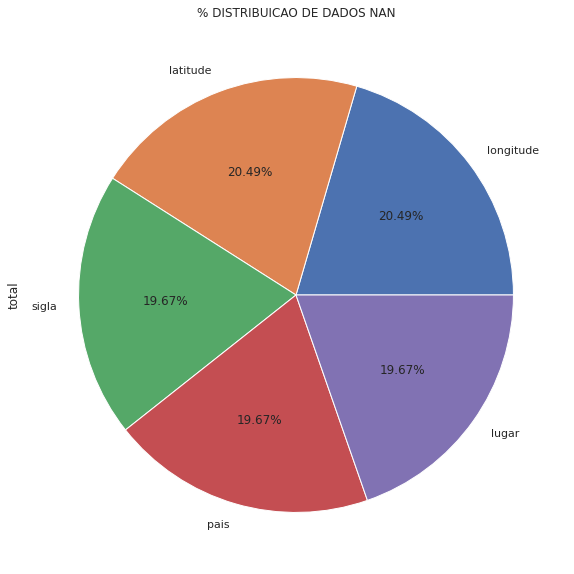

In [74]:
df_plot = df.isnull().sum().sort_values(ascending=False).to_frame(name='total').head()
df_isnull_plot = df_plot['total'].dropna()
plot = df_isnull_plot.plot.pie(y='total', figsize=(10, 10), autopct='%1.2f%%')
plot.set_title('% DISTRIBUICAO DE DADOS NAN')

Excluindo as colunas sem representatividade, executando um 'Describe' , conseguimos alguns dados como: max de 'seguidores' e 'retweet'.

In [75]:
df_describe = df[['data','seguidores', 'retweet']].describe()
df_describe['seguidores'] = df_describe['seguidores'].apply(formata_valor)
df_describe['retweet'] = df_describe['retweet'].apply(formata_valor)
df_describe

,seguidores,retweet
count,1 658 825.00,1 658 825.00
mean,32 572.06,197.85
std,368 029.99,6 337.64
min,0.00,0.00
25%,101.00,0.00
50%,380.00,0.00
75%,1 470.00,0.00
max,84 241 250.00,1 139 763.00


## Sumarizando Classificação

Podemos notar que o assunto mais falado foi sobre a doença

Text(0.5, 1.0, 'DISTRIBUICAO DE CLASSES')

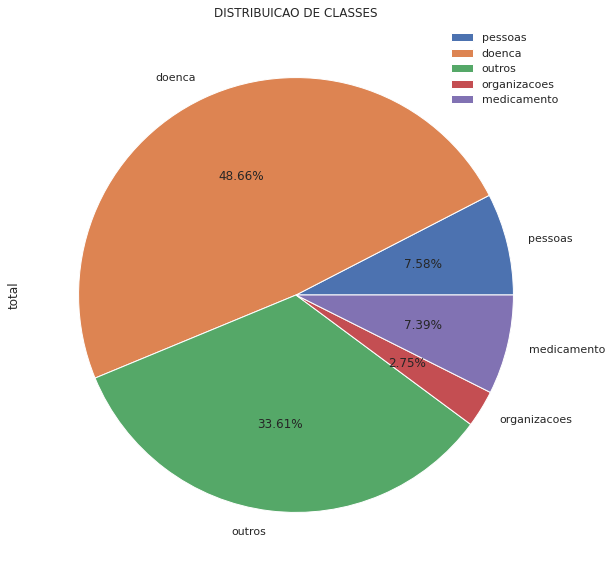

In [153]:
df_classes = {}

for idx, rows in DuvidasDB.iterrows():
  for cls in rows['classe'].split(','):
    cls = cls.strip()
    if cls not in df_classes:
      df_classes[cls] = 0
    df_classes[cls] += 1

df_classes = pd.DataFrame(df_classes, index=['total']).T

plot = df_classes.plot.pie(y='total', figsize=(10, 10), autopct='%1.2f%%')
plot.set_title('DISTRIBUICAO DE CLASSES')

Pessoas que falavam sobre doença, também escreviam sobre organizações e medicamentos


In [ ]:
df_plot_classes = DuvidasDB.value_counts('classe').to_frame(name='total')
df_plot_classes

,total
classe,
doenca,83527
outros,58571
medicamento,12184
pessoas,12110
organizacoes,4368
"doenca,pessoas",669
"medicamento,pessoas",344
"medicamento,doenca",297
"organizacoes,doenca",294


* No gráfico abaixo, é possível notar que os meses MAR, ABR e MAI foram os que tiveram mais twitters sobre coronavirus

Text(0.5, 1.0, '% DE TWITTER POR MES/ANO')

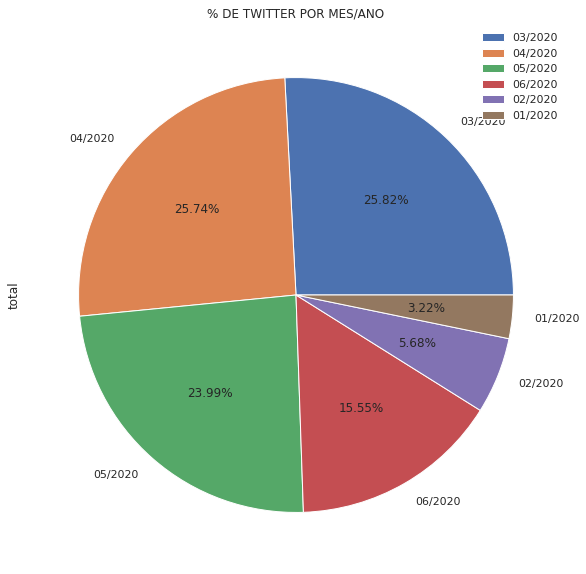

In [77]:
df_short_date = pd.to_datetime(DuvidasDB['data']).dt.strftime('%m/%Y')
df_short_date = df_short_date.value_counts(ascending=False)
df_short_date = df_short_date.to_frame(name='total')
# plot chart
plot = df_short_date.plot.pie(y='total', figsize=(10, 10), autopct='%1.2f%%')
plot.set_title('% DE TWITTER POR MES/ANO')

* Podemos visualizar melhor, no gráfico em linha, o número das postagens durante os meses analisados.

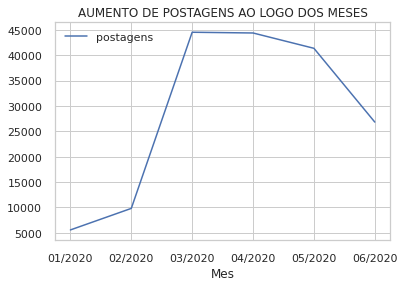

In [78]:
df_line_date = pd.to_datetime(DuvidasDB['data']).dt.strftime('%m/%Y')
df_line_date = df_line_date.value_counts(ascending=False)
df_line_date = df_line_date.to_frame(name='postagens')
df1 = pd.DataFrame(df_line_date, columns=['data','postagens']).reset_index()
df1 = df1.rename(columns = {'index': 'Mes'}, inplace = False)
df1 = df1.sort_values(by='Mes')
df1.plot(x ='Mes', y='postagens', kind = 'line')
#criar titulo grafico 'aumento do  ume ro de perguntas'
plt.title('AUMENTO DE POSTAGENS AO LOGO DOS MESES')
plt.show()

* Percentual de questionamentos por lugar

Text(0.5, 1.0, 'TOP 10 CIDADES COM MAIOR ÍNDICE DE POSTAGEM')

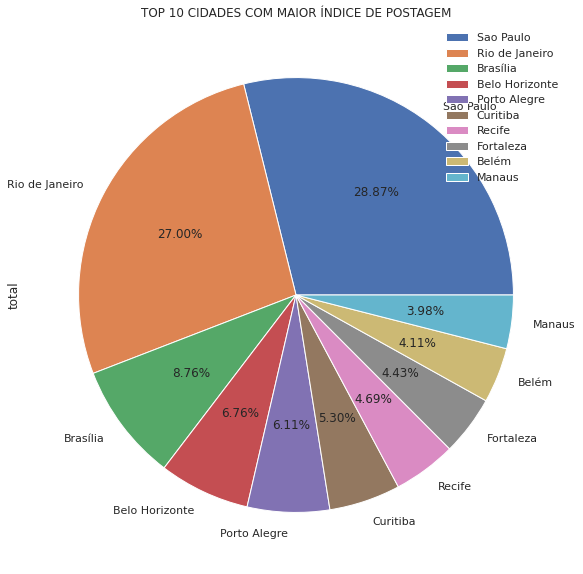

In [79]:
df_places = DuvidasDB['lugar'].dropna()
df_places = df_places.value_counts(ascending=False)
df_places = df_places.head(10).to_frame(name='total')

# plot chart
plot = df_places.plot.pie(y='total', figsize=(10, 10), autopct='%1.2f%%')
plot.set_title('TOP 10 CIDADES COM MAIOR ÍNDICE DE POSTAGEM')

In [86]:
#usuário com maior numero de seguidores 
dfs = DuvidasDB.copy()
# dfs1 = dfs[['usuario','texto','seguidores','retweet','pais']]
#dfs = dfs.set_index('pais')
#dfs = dfs.loc['Brazil']
#dfs = dfs.loc[(dfs2['seguidores']) > 0]
dfs.max()

Unnamed: 0                                              1658821
data                                        2020-06-30 23:59:57
apelido                                                 zzzzxup
texto         ['🥋😀 Bora treinar Karate durante o período de ...
retweet                                                  616569
seguidores                                             13104119
idioma                                                       zh
latitude                                                151.629
longitude                                               52.8864
hashtags                                                     []
pergunta       {'🦁\nE agora, que eu faço eu da vida sem você?'}
classe                                              {'pessoas'}
dtype: object

In [ ]:
# Removendo colunas não úteis para análise
colunas = df[['usuario','idioma', 'lugar', 'pais', 'retweet', 'seguidores']]

In [ ]:
# Removendo linhas em branco
df_places = colunas[['usuario','pais','lugar','retweet', 'seguidores' ]].dropna()
df_places

,usuario,pais,lugar,retweet,seguidores
4,Nova Impressão,Brazil,Brasília,0,124
5,Marcel Silvano,Brazil,Macaé,4,2769
14,baby,Brazil,Angra dos Reis,0,507
76,Andreia Santana,Brazil,Patos de Minas,0,115
77,Gus,Brazil,Santos,3,253
...,...,...,...,...,...
1658760,Hamilton Valerio,Brazil,Jaboatão dos Guararapes,0,176
1658773,Eliseu Subs Oficial,Brazil,Siqueira Campos,0,1
1658799,Wallan lanh,Brazil,Sao Paulo,0,112
1658816,highest in the room,Brazil,Assis,0,497


In [ ]:
#usuário com maior numero de seguidores 
dfs = df_places.copy()
dfs1 = dfs.set_index('pais')
dfs2 = dfs1.loc['Brazil']
dfs3 = dfs2.loc[(dfs2['seguidores']) > 0]
dfs3.max()
#dfs.loc[dfs['Total'] == dfs.groupby(['lugar','seguidores'])['Total'].transform('max')]
#dfs = dfs.groupby(['lugar','seguidores'])['lugar'].count().reset_index(name="Total")


usuario           🧸lo
lugar          Óbidos
retweet         17697
seguidores    9468554
dtype: object

In [ ]:
dfr_places = colunas[['usuario','pais','lugar','retweet', 'seguidores']].dropna()
dfr_places
dfr = dfr_places.copy()
#dfr1 = dfr.set_index('pais')
#dfr2 = dfr1.loc['Brazil']
#dfr3 = dfr2.loc[(dfr2['retweet']) > 0]
dfr.retweet.max()

17697

In [ ]:
df_questions['texto'] = df_questions['texto'].apply(lambda t: np.nan if '?' not in t else t)
df_questions = df_questions[df_questions['texto'].notna()]
df_questions

NameError: ignored

In [ ]:
# Removendo colunas não úteis para análise
col_retweet = df_questions[['seguidores','pais','usuario','retweet']].dropna(how='all')
col_retweet

NameError: ignored

In [ ]:
#Comentário com maior numero de retweet: 
#lista_retweet =  col_retweet.to_numpy()

lista_retweet = [col_retweet.columns.values.tolist()] + col_retweet.values.tolist()
lista_retweet
#lista_ordem_dec = lista_retweet.sort(reverse=True)
#print(lista_ordem_dec)


NameError: ignored

In [ ]:
#totais de itens não preenchidos
df.isna().sum()

data                0
usuario            57
apelido             0
texto               0
retweet             0
seguidores          0
idioma              0
lugar         1584220
pais          1584225
sigla         1584230
latitude      1650105
longitude     1650105
hashtags            0
dtype: int64

In [ ]:
#dados preenchidos
count_data = df.count()
count_data

data          1658825
usuario       1658768
apelido       1658825
texto         1658825
retweet       1658825
seguidores    1658825
idioma        1658825
lugar           74605
pais            74600
sigla           74595
latitude         8720
longitude        8720
hashtags      1658825
dtype: int64

In [ ]:
def extract_questions(text: str):
    splited = re.split('(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s', text.replace('\n', ''))
    sentences = [s.strip() for s in splited if '?' in s.strip()] 
    return sentences

In [ ]:
# extract questions from text
df_questions['texto'] = df_questions['texto'].apply(extract_questions)

In [ ]:
df_questions

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-03-23 18:51:14,Gaboardi,fraslee,[@BolsonaroSP Cade o fundão deputado???],0,138,pt,NaN,NaN,NaN,NaN,NaN,[]
3,2020-04-01 21:11:07,🚩,santosodeto,[Fumaça de cigarro pode propagar coronavírus?],0,1885,pt,NaN,NaN,NaN,NaN,NaN,[]
38,2020-06-25 11:09:19,Andreia Peraro,AndreiaPeraro,[@ipratesMD @dr_pampers Será que corremos o ri...,0,86,pt,NaN,NaN,NaN,NaN,NaN,[]
45,2020-04-06 15:44:36,Diorgenes Pandini,diorpandini,[Prioridade ?!],0,219,pt,NaN,NaN,NaN,NaN,NaN,"['COVID19', 'floripa', 'isolamento']"
57,2020-03-30 00:43:36,Valnei do Val,vdoval,"[Que tal uma notícia boa, indo na contramão do...",0,201,pt,NaN,NaN,NaN,NaN,NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658795,2020-03-24 23:50:14,solineuza da diarista,gtstayhigh,[E ai quem são vcs durante a quarentena?],0,1329,pt,NaN,NaN,NaN,NaN,NaN,[]
1658810,2020-03-26 21:43:24,Chris CP,Chris_CP_,"[@0n3p1ece @alexmono Oh jumentinha, 1918 é iss...",0,34,pt,NaN,NaN,NaN,NaN,NaN,[]
1658818,2020-05-25 22:53:13,O que houve com a couve?,couveluiza,[@BiologiaBraba @Tati_Cordeiro Só vontade ou v...,0,1883,pt,NaN,NaN,NaN,NaN,NaN,[]
1658820,2020-03-13 17:26:18,broca,whoisdrill,[oms: tamo tendo pandemia evitar conglomerados...,0,361,pt,NaN,NaN,NaN,NaN,NaN,[]


In [ ]:
# Removendo colunas não úteis para análise
s = df_questions[['usuario','idioma', 'lugar', 'pais', 'retweet', 'seguidores']]
#s2= s.sort_values(by='seguidores')



,usuario,idioma,lugar,pais,retweet,seguidores
223877,Luiz Ramires,pt,Sao Paulo,Brazil,0,0
688412,José Maria Alves Cabral,pt,Castanhal Cidade Modelo,Brazil,0,0
254551,diego_,pt,Rio de Janeiro,Brazil,0,0
201158,José Maria Alves Cabral,pt,Castanhal Cidade Modelo,Brazil,0,0
168135,Na,pt,Pão de Açúcar,Brazil,0,0
...,...,...,...,...,...,...
32683,rosana hermann,pt,Sao Paulo,Brazil,10,618974
961126,rosana hermann,pt,Sao Paulo,Brazil,4,619328
933315,Leo Picon ◟̽◞̽ 🪐,pt,Sao Paulo,Brazil,24,701738
1248338,Ricardo Amorim,pt,Sao Paulo,Brazil,1,1419433


In [ ]:
s2 = s.values.tolist()
print(s2)

[['Gus', 253], ['Sher Machado', 21791], ['Diego M 🇪🇪', 892], ['De cola', 590], ['.Nathi 🐨', 964], ['Miss Vanjie', 2391], ['Monster3366', 6], ['Paulo Menezes', 169], ['🚩Fabiano Rodrigues ®️', 820], ['Suavemente recolhida...', 187], ['Fabricio Lopes', 105], ['Guilherme Moreira ♻️', 46], ['Afonso Rebelo', 128], ['Mr Divago™', 3240], ['Pablotelli', 529], ['Sheila Rangel PL2630NAO 💯% PR 🇧🇷', 1251], ['tembase', 1294], ['Raphael Noutel', 1067], ['CãoPanheiro', 2], ['RAFAEL MAIA #DEMOCRACIA', 203], ['youtube: /jujubasena', 566], ['Rosa Neta', 19], ['Ronaldo Guedes', 3381], ['𝙂𝙪𝙞𝙡𝙝𝙚𝙧𝙢𝙚 𝘾𝙖𝙢𝙥𝙤𝙨 ⃝⃒⃤', 362], ['Marcelo Ferraro +Democracia', 1031], ['Florisvaldo Raimundo', 12694], ['Francis Schonarth', 1409], ['Malta Visionário seu presidenciavel.', 2], ['genipapoabsoluto', 126], ['Eduardo Cosso', 868], ['C. Vinicius D.', 1379], ['M1newsTv Maricá Notícias', 237], ['Saad Ahmed Khan', 8], ['SENHOR🇧🇷GRIMALDI🇧🇷PAULISTA🇧🇷', 4446], ['90.212 // matheus', 448], ['Antônio Carlos', 14], ['Franco Junior', 294],

In [ ]:
#removida as linhas vazias do DataFrame 's'
df_seg = df['pais'].dropna()




In [ ]:
df_questions.isna().sum()



data             0
usuario          0
apelido          0
texto            0
retweet          0
seguidores       0
idioma           0
lugar            0
pais             0
sigla            0
latitude      7237
longitude     7237
hashtags         0
dtype: int64

In [ ]:
#contagem de dados nao nulo
df_questions.count()

data          172501
usuario       172495
apelido       172501
texto         172501
retweet       172501
seguidores    172501
idioma        172501
lugar           7829
pais            7829
sigla           7829
latitude         594
longitude        594
hashtags      172501
dtype: int64

In [ ]:
df_questions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172501 entries, 0 to 1658821
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   data        172501 non-null  object 
 1   usuario     172495 non-null  object 
 2   apelido     172501 non-null  object 
 3   texto       172501 non-null  object 
 4   retweet     172501 non-null  int64  
 5   seguidores  172501 non-null  int64  
 6   idioma      172501 non-null  object 
 7   lugar       7829 non-null    object 
 8   pais        7829 non-null    object 
 9   sigla       7829 non-null    object 
 10  latitude    594 non-null     float64
 11  longitude   594 non-null     float64
 12  hashtags    172501 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 18.4+ MB


In [ ]:
from unicodedata import normalize

def _normalize(value: str):
  value = normalize('NFKD', str(value)).encode('ASCII', 'ignore').decode('ASCII')
  # value = re.sub(r'^[\W|\d]+', '', value)
  return value.strip().upper()

In [ ]:
import nltk
results = []
for sentence in df_questions['texto']:
    sentence_results = set()
    for s in sentence:
        sentence_results.add(nltk.word_tokenize(s))
    results.append(sentence_results)

TypeError: ignored

In [ ]:
results

[[['@', 'BolsonaroSP', 'Cade', 'o', 'fundão', 'deputado', '?', '?', '?']],
 [['Fumaça', 'de', 'cigarro', 'pode', 'propagar', 'coronavírus', '?']],
 [['@',
   'ipratesMD',
   '@',
   'dr_pampers',
   'Será',
   'que',
   'corremos',
   'o',
   'risco',
   'de',
   'termos',
   'piolhos',
   'super',
   'resistentes',
   '?']],
 [['Prioridade', '?', '!']],
 [['Que',
   'tal',
   'uma',
   'notícia',
   'boa',
   ',',
   'indo',
   'na',
   'contramão',
   'do',
   'que',
   'a',
   'mídia',
   'corrupta',
   'está',
   'fazendo',
   '(',
   'tocando',
   'o',
   'terror',
   'na',
   'população',
   ')',
   '?',
   'Sã…',
   'https',
   ':',
   '//t.co/kpfUtx089E']],
 [['@',
   'JoseMedeirosMT',
   'Seria',
   'isso',
   'algum',
   'tipo',
   'aleatório',
   'de',
   'demência',
   'provocando',
   'pelo',
   'coronavírus',
   '?']],
 [['``',
   'Nova',
   'York',
   'é',
   'o',
   'novo',
   'epicentro',
   'da',
   'pandemia',
   'de',
   'corona',
   'vírus',
   "''",
   'Ta',
   'a

In [ ]:
words = dict()

for questions in df_questions['texto']:
  for q in questions:
    for w in q.split(' '):
      if not (w.startswith('http')):
        word_normalized = _normalize(w)
        if len(word_normalized):
          words.setdefault(word_normalized[0], set())
          words[word_normalized[0]].add(word_normalized)

In [ ]:
# words = sorted(words)
words['A']

In [ ]:
re.sub('^[\W|\d]+', '', '007ALISOHRAB')

'ALISOHRAB'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1658825 entries, 0 to 1658824
Data columns (total 13 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   data        1658825 non-null  object 
 1   usuario     1658768 non-null  object 
 2   apelido     1658825 non-null  object 
 3   texto       1658825 non-null  object 
 4   retweet     1658825 non-null  int64  
 5   seguidores  1658825 non-null  int64  
 6   idioma      1658825 non-null  object 
 7   lugar       74605 non-null    object 
 8   pais        74600 non-null    object 
 9   sigla       74595 non-null    object 
 10  latitude    8720 non-null     float64
 11  longitude   8720 non-null     float64
 12  hashtags    1658825 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 164.5+ MB


Text(0.5, 1.0, 'CIDADES COM MAIOR ÍNDICE DE POSTAGEM')

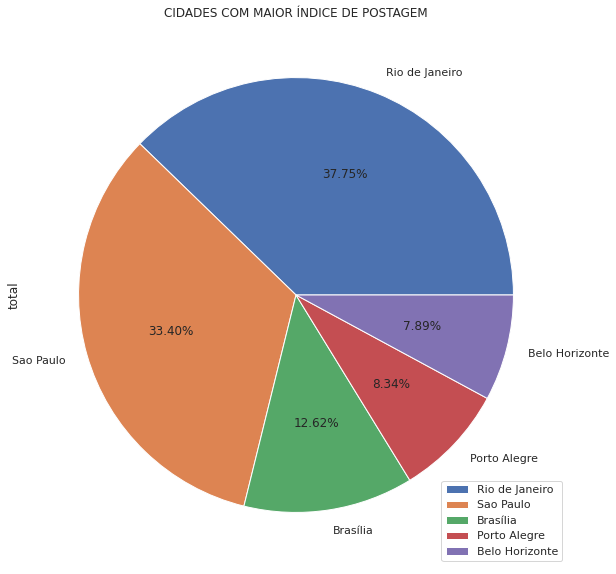

In [ ]:
df_places = df['lugar'].dropna()
df_places = df_places.value_counts(ascending=False)
df_places = df_places.head().to_frame(name='total')

# plot chart
plot = df_places.plot.pie(y='total', figsize=(10, 10), autopct='%1.2f%%')
plot.set_title('CIDADES COM MAIOR ÍNDICE DE POSTAGEM')

Text(0.5, 1.0, '% DE TWITTER POR MES/ANO')

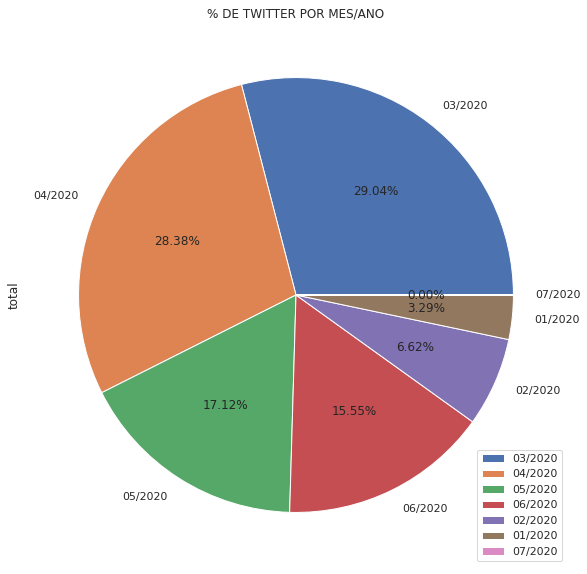

In [ ]:
df_short_date = pd.to_datetime(df['data']).dt.strftime('%m/%Y')
df_short_date = df_short_date.value_counts(ascending=False)
df_short_date = df_short_date.to_frame(name='total')

# plot chart
plot = df_short_date.plot.pie(y='total', figsize=(10, 10), autopct='%1.2f%%')
plot.set_title('% DE TWITTER POR MES/ANO')